In [4]:
"""
Diabetes Prediction using KNN with Optuna Hyperparameter Optimization
---------------------------------------------------------------------
This script includes data preprocessing, model training, hyperparameter tuning,
and evaluation using KNN classifier on the Diabetes dataset.
"""

# Core Libraries
import warnings
from collections import Counter

import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Scikit-learn Modules
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Imbalanced Data Handling
from imblearn.over_sampling import BorderlineSMOTE

# Hyperparameter Optimization
import optuna
from optuna.samplers import GridSampler, RandomSampler

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")


Loading the Dataset for the analysis

In [5]:
data=pd.read_csv("/content/sample_data/Dataset of Diabetes .csv")

In [6]:
data.shape,data.size

((1000, 14), 14000)

In [7]:
data.head()

,ID,No_Pation,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,502,17975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,735,34221,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,420,47975,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,680,87656,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,504,34223,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N


In [9]:
# Checking the basic information of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         1000 non-null   int64  
 1   No_Pation  1000 non-null   int64  
 2   Gender     1000 non-null   object 
 3   AGE        1000 non-null   int64  
 4   Urea       1000 non-null   float64
 5   Cr         1000 non-null   int64  
 6   HbA1c      1000 non-null   float64
 7   Chol       1000 non-null   float64
 8   TG         1000 non-null   float64
 9   HDL        1000 non-null   float64
 10  LDL        1000 non-null   float64
 11  VLDL       1000 non-null   float64
 12  BMI        1000 non-null   float64
 13  CLASS      1000 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 109.5+ KB


In [10]:
data.isnull().sum()

,0
ID,0
No_Pation,0
Gender,0
AGE,0
Urea,0
Cr,0
HbA1c,0
Chol,0
TG,0
HDL,0


Observations:

The dataset does not contain any null values.

The columns ID and No_Patient contain all unique values and are not useful for prediction according to the problem statement. Therefore, they will be removed.

In [11]:
data=data.drop(["ID","No_Pation"],axis=1)

In [12]:
data

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
0,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
1,M,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0,N
2,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
3,F,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0,N
4,M,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...
995,M,71,11.0,97,7.0,7.5,1.7,1.2,1.8,0.6,30.0,Y
996,M,31,3.0,60,12.3,4.1,2.2,0.7,2.4,15.4,37.2,Y
997,M,30,7.1,81,6.7,4.1,1.1,1.2,2.4,8.1,27.4,Y
998,M,38,5.8,59,6.7,5.3,2.0,1.6,2.9,14.0,40.5,Y


In [13]:
data.duplicated().sum()

np.int64(169)

In [14]:
data.drop_duplicates(inplace=True)

In [15]:
# Checking the statistical summary of the dataset
data.describe()

,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
count,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000
mean,53.418773,5.183566,68.971119,8.332202,4.896053,2.395283,1.211974,2.591083,1.810710,29.487918
std,8.870302,3.070515,59.393210,2.607280,1.326116,1.453699,0.678072,1.129763,3.571375,5.006987
min,20.000000,0.500000,6.000000,0.900000,0.000000,0.300000,0.200000,0.300000,0.100000,19.000000
25%,51.000000,3.630000,48.000000,6.500000,4.000000,1.500000,0.900000,1.700000,0.700000,26.000000
50%,55.000000,4.600000,59.000000,8.100000,4.800000,2.000000,1.100000,2.500000,1.000000,30.000000
75%,59.000000,5.700000,73.000000,10.200000,5.600000,3.000000,1.300000,3.300000,1.500000,33.000000
max,79.000000,38.900000,800.000000,16.000000,10.300000,13.800000,9.900000,9.900000,35.000000,47.750000


# Checking for outliers in the dataset and handling them if necessary


In [16]:
# Identifying potential outliers by checking the skewness of each numerical column
data.skew(numeric_only=True)

,0
AGE,-0.813706
Urea,4.264092
Cr,8.168990
HbA1c,0.189050
Chol,0.579300
TG,2.302848
HDL,6.302161
LDL,1.004766
VLDL,5.690278
BMI,0.081198


Observations:

The columns Urea, Cr, TG, HDL, LDL, and VLDL exhibit high skewness, indicating that they may require further analysis or transformation.

In [17]:
#Checking Distribution for Categorical Columns
data.select_dtypes(include="object")

,Gender,CLASS
0,F,N
1,M,N
4,M,N
5,F,N
6,F,N
...,...,...
995,M,Y
996,M,Y
997,M,Y
998,M,Y


<Axes: xlabel='Gender', ylabel='count'>

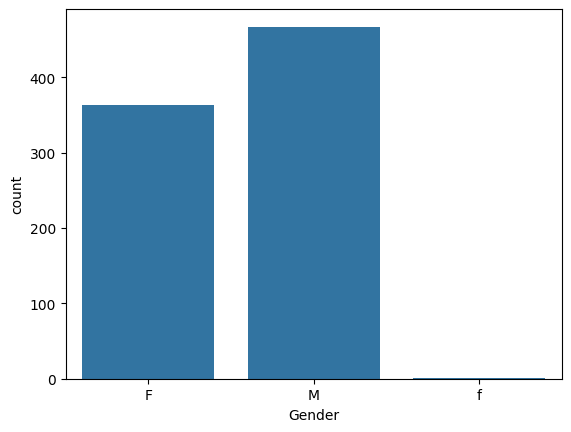

In [18]:
sns.countplot(x=data["Gender"])

<Axes: xlabel='CLASS', ylabel='count'>

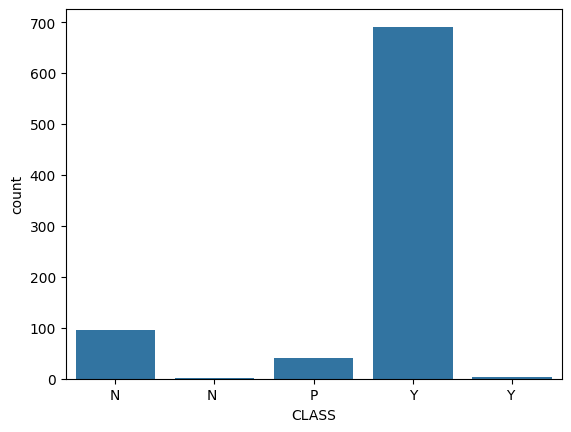

In [19]:
sns.countplot(x=data["CLASS"])

In [20]:
data["CLASS"].unique()

array(['N', 'N ', 'P', 'Y', 'Y '], dtype=object)

In [21]:
data["Gender"].value_counts()

,count
Gender,
M,467
F,363
f,1


In [22]:
data['Gender']=data['Gender'].str.upper()

Observations:

Leading spaces in the CLASS column values should be removed to unify the categories.

The Gender column values should be standardized by replacing "f" with "F".

In [24]:
data['CLASS'] = data['CLASS'].str.strip()

In [25]:
data["CLASS"].unique()

array(['N', 'P', 'Y'], dtype=object)

<Axes: xlabel='CLASS', ylabel='count'>

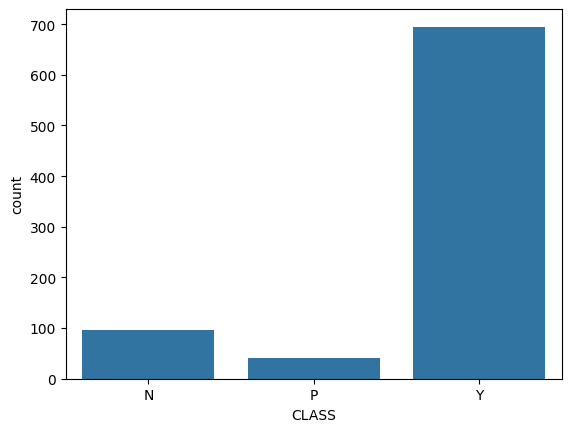

In [26]:
sns.countplot(x=data["CLASS"])

Observations:

The CLASS column is imbalanced, which needs to be addressed using techniques like SMOTE.

In [27]:
#Checking Distribution for Numerical Columns
num_columns = data.select_dtypes(include="number").columns
num_columns

Index(['AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL', 'VLDL',
       'BMI'],
      dtype='object')

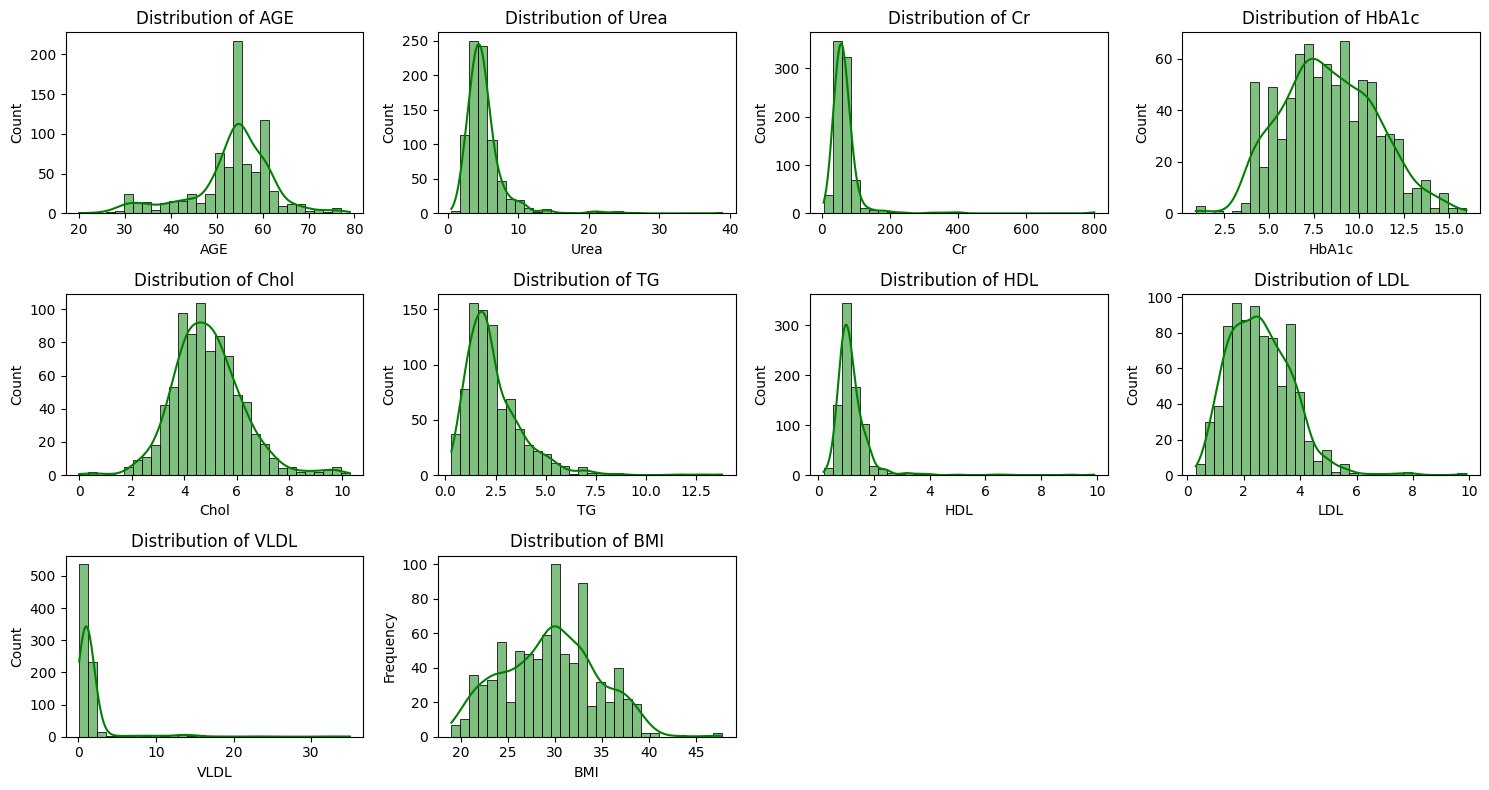

In [28]:
plt.figure(figsize=(15, 8))
for i, cl in enumerate(num_columns, 1):
    plt.subplot(3, 4, i)
    sns.histplot(data[cl], kde=True, bins=30, color='green')
    plt.title(f"Distribution of {cl}")
plt.xlabel(cl)
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Observations:

The columns Urea, Cr, TG, HDL, LDL, and VLDL contain outliers, which need to be handled appropriately.

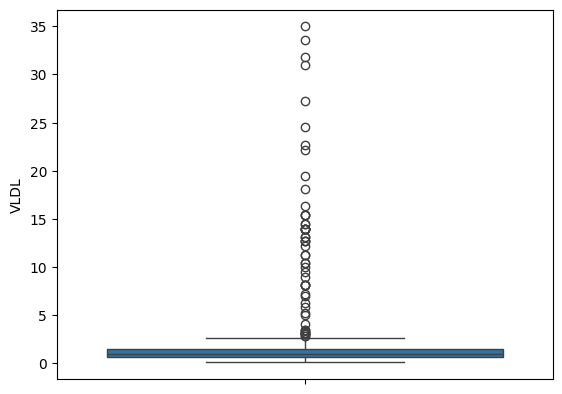

In [29]:
# Visualizing the data distribution and detecting outliers using Box plot, Histogram, and KDE plot
# Currently displaying a Box plot for the 'VLDL' column
sns.boxplot(data=data, y="VLDL")
plt.show()


In [31]:
# Calculating Interquartile Range (IQR) and the upper & lower bounds to detect outliers in the 'Urea' column
q1, q2, q3 = data["Urea"].quantile(q=[0.25, 0.5, 0.75])

iqr = q3 - q1
ub = q3 + 1.5 * iqr  # Upper bound
lb = q1 - 1.5 * iqr  # Lower bound

# Uncomment the next line to view the quartiles, IQR, and bounds
# print(q1, q2, q3, iqr, ub, lb, sep="\n")


In [33]:
mu = data.Urea.mean()
sd = data.Urea.std()
UL = mu+2*sd
LL = mu-2*sd
#print(mu, sd, UL, LL, sep = "\n")

In [35]:
# Checking skewness after excluding outliers using IQR-based approach
print(data[data.Urea < ub]["Urea"].skew())

# Checking skewness after excluding outliers using Standard Deviation-based approach
data[data.Urea < UL]["Urea"].skew()


0.4253422763451648


np.float64(1.0663608501356086)

Observations:

The IQR-based outlier handling approach will be used, as it reduces skewness more effectively compared to the Standard Deviation-based approach.

In [37]:
outliers_columns=["Urea","Cr","TG","HDL","LDL","VLDL"]

In [38]:
data.skew(numeric_only=True)

,0
AGE,-0.813706
Urea,4.264092
Cr,8.168990
HbA1c,0.189050
Chol,0.579300
TG,2.302848
HDL,6.302161
LDL,1.004766
VLDL,5.690278
BMI,0.081198


In [39]:
data_clean=data.copy()

In [40]:
# Function to cap outliers based on given lower and upper percentiles
def cap_outliers_percentile(series, lower_percentile=0.01, upper_percentile=0.99):
    lower = series.quantile(lower_percentile)
    upper = series.quantile(upper_percentile)
    return series.clip(lower, upper)

# Apply capping to reduce the effect of extreme outliers
data_clean['Cr'] = cap_outliers_percentile(data_clean['Cr'], 0.05, 0.95)       # Very extreme values
data_clean['Urea'] = cap_outliers_percentile(data_clean['Urea'], 0.05, 0.95)
data_clean['VLDL'] = cap_outliers_percentile(data_clean['VLDL'], 0.05, 0.95)
data_clean['TG'] = cap_outliers_percentile(data_clean['TG'], 0.05, 0.95)
data_clean['HDL'] = cap_outliers_percentile(data_clean['HDL'], 0.05, 0.95)
data_clean['LDL'] = cap_outliers_percentile(data_clean['LDL'], 0.05, 0.95)


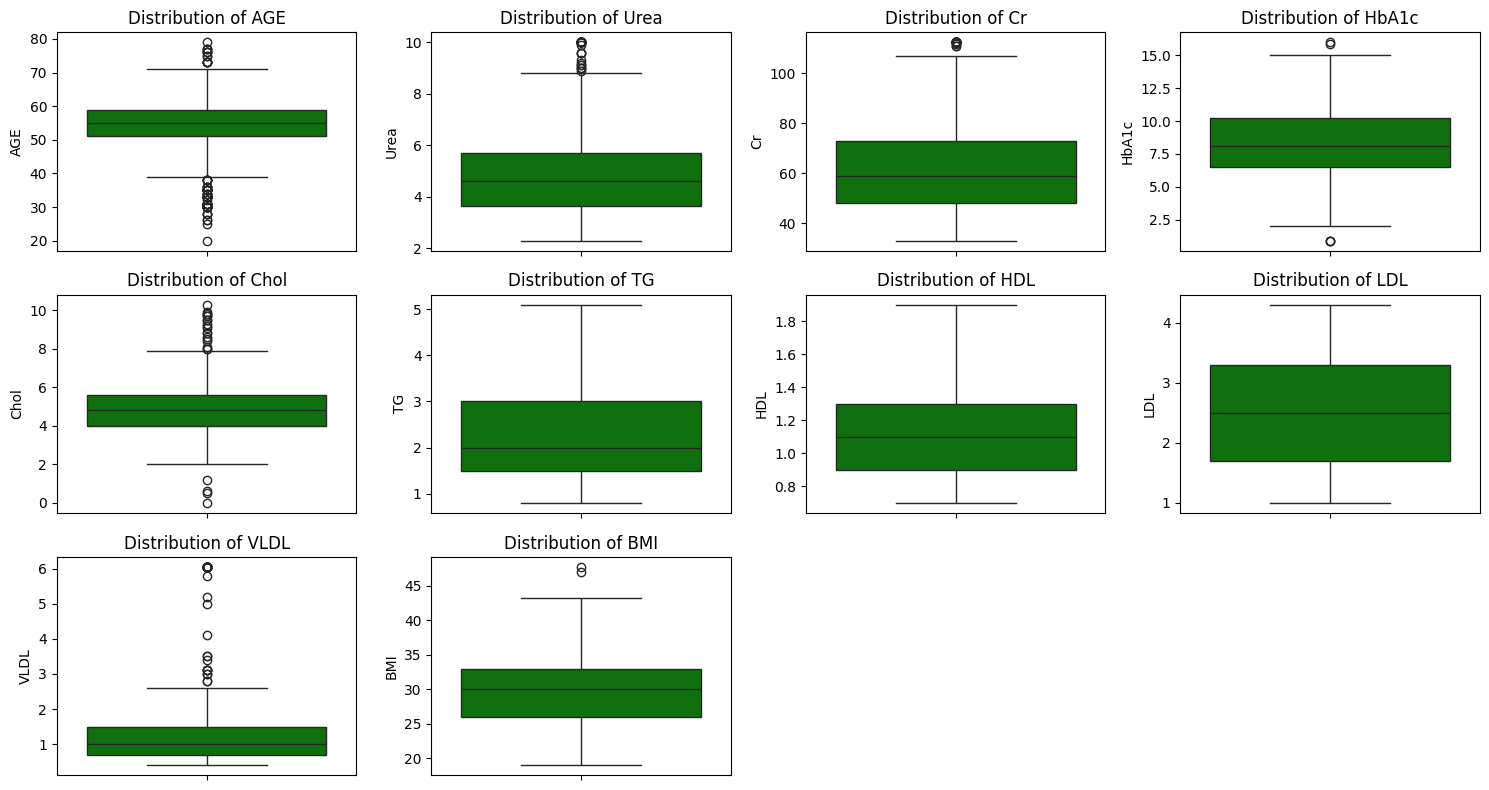

In [44]:
# Visualizing the distribution of numerical columns and checking for outliers using boxplots
plt.figure(figsize=(15, 8))

for i, cl in enumerate(num_columns, 1):
    plt.subplot(3, 4, i)
    sns.boxplot(data=data_clean, y=cl,color='green')          # Boxplot for outlier detection
    plt.title(f"Distribution of {cl}")

plt.tight_layout()
plt.show()


In [45]:
data_clean.shape

(831, 12)

In [46]:
# Checking skewness of numerical columns after outlier treatment and data cleaning
data_clean.skew(numeric_only=True)


,0
AGE,-0.813706
Urea,1.063070
Cr,0.749265
HbA1c,0.189050
Chol,0.579300
TG,0.885893
HDL,0.736612
LDL,0.172648
VLDL,2.916215
BMI,0.081198


In [47]:
# Applying Log Transform to reduce skewness
data_clean['VLDL'] = np.log1p(data_clean['VLDL'])
data_clean.skew(numeric_only=True)

,0
AGE,-0.813706
Urea,1.063070
Cr,0.749265
HbA1c,0.189050
Chol,0.579300
TG,0.885893
HDL,0.736612
LDL,0.172648
VLDL,1.736067
BMI,0.081198


In [48]:
data_clean.describe()

,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
count,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000,831.000000
mean,53.418773,4.947344,62.589651,8.332202,4.896053,2.328014,1.153309,2.548231,0.770464,29.487918
std,8.870302,1.913358,20.551275,2.607280,1.326116,1.174197,0.343272,0.972275,0.365389,5.006987
min,20.000000,2.300000,33.000000,0.900000,0.000000,0.800000,0.700000,1.000000,0.336472,19.000000
25%,51.000000,3.630000,48.000000,6.500000,4.000000,1.500000,0.900000,1.700000,0.530628,26.000000
50%,55.000000,4.600000,59.000000,8.100000,4.800000,2.000000,1.100000,2.500000,0.693147,30.000000
75%,59.000000,5.700000,73.000000,10.200000,5.600000,3.000000,1.300000,3.300000,0.916291,33.000000
max,79.000000,10.000000,112.500000,16.000000,10.300000,5.100000,1.900000,4.300000,1.953028,47.750000


In [49]:
data_clean[data_clean["CLASS"]=="P"]

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI,CLASS
103,M,34,3.9,81.0,6.0,6.2,3.9,0.80,1.90,1.029619,23.0,P
104,M,34,3.9,81.0,6.0,6.2,3.9,0.80,3.80,1.029619,23.0,P
106,M,31,3.4,55.0,5.7,4.9,1.6,1.00,3.20,0.530628,24.0,P
108,F,43,2.3,55.0,5.7,4.7,5.1,0.90,1.70,1.223775,25.0,P
109,M,42,5.4,53.0,5.8,5.9,3.7,1.30,3.10,0.993252,23.0,P
110,M,47,4.1,87.0,6.2,3.7,1.8,1.00,2.00,0.587787,23.0,P
111,M,50,4.3,59.0,6.1,4.0,3.0,1.00,1.80,0.832909,24.0,P
112,M,49,5.0,74.0,6.2,2.0,0.8,0.70,1.00,0.336472,25.0,P
113,M,50,4.7,53.0,6.1,4.2,2.2,0.80,2.50,0.641854,25.0,P
114,M,49,3.5,59.0,6.0,4.0,2.1,1.40,1.90,0.641854,24.0,P


NOTE:

After outlier treatment and data cleaning, the skewness in the dataset has been effectively reduced.

In [ ]:
#Checking Correlation between features

In [50]:
corr_mat = data_clean.corr(numeric_only=True)

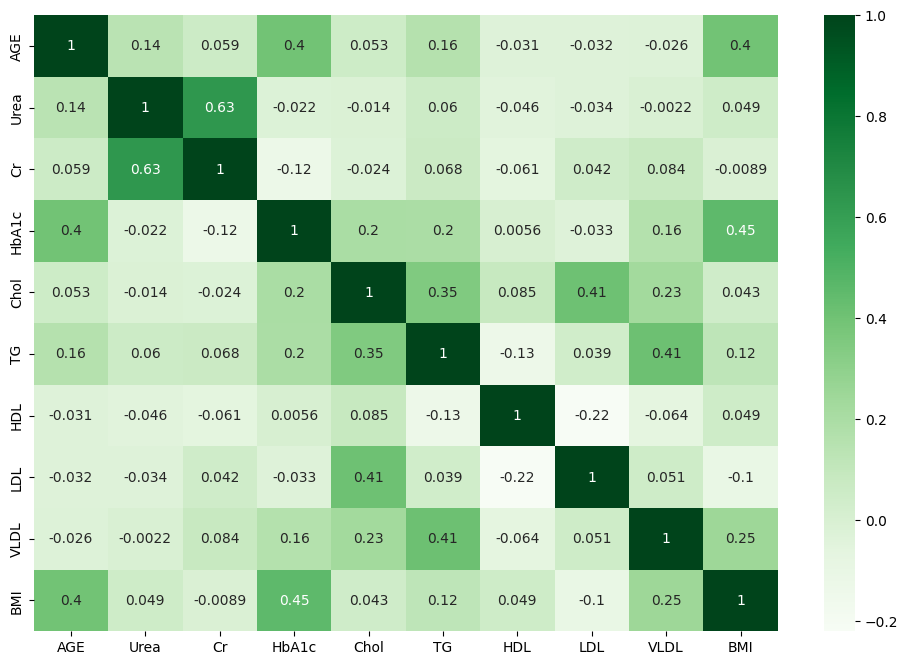

In [51]:
plt.figure(figsize=(12, 8))
sns.heatmap(corr_mat, annot=True,  cmap="Greens")
plt.show();

The columns Cr and Urea have the highest correlation in the dataset

In [52]:
# Finding correlation between CLASS and Gender (Categorical vs Categorical)

from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(data_clean['CLASS'], data_clean['Gender'])

# Perform Chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

# Optional: Calculate Cramer's V
# from scipy.stats import contingency
# cramer_v = contingency.association(contingency_table)

print("Chi-squared statistic:", chi2)
print("P-value:", p)
# print("Cramer's V:", cramer_v)


Chi-squared statistic: 13.604082133262727
P-value: 0.0011115041769455532


## **Finding Important Featues(Feature Selection)**

In [54]:
# Applying ANOVA F-test to identify the relationship between categorical target and numerical features

from sklearn.feature_selection import f_classif

# Numerical features
X_num = data_clean[num_columns]

# Target variable
y = data_clean["CLASS"]

# Compute F-scores and p-values
f_values, p_values = f_classif(X_num, y)

# Display F-score and p-value for each numerical feature
for col, f, p in zip(X_num.columns, f_values, p_values):
    print(f"{col}: F-score = {f:.2f}, p-value = {p:.4f}")

# Note: Higher F-value indicates a more important feature


AGE: F-score = 117.13, p-value = 0.0000
Urea: F-score = 4.00, p-value = 0.0186
Cr: F-score = 0.16, p-value = 0.8524
HbA1c: F-score = 204.19, p-value = 0.0000
Chol: F-score = 19.29, p-value = 0.0000
TG: F-score = 20.31, p-value = 0.0000
HDL: F-score = 0.22, p-value = 0.8006
LDL: F-score = 0.88, p-value = 0.4153
VLDL: F-score = 16.42, p-value = 0.0000
BMI: F-score = 219.66, p-value = 0.0000


Observations:

Based on the analysis, Age, HbA1c, and BMI are highly important features for prediction.

Urea, Chol, TG, and VLDL show moderate usefulness for prediction.

The remaining columns contribute little to the analysis and may not be useful for modeling.

| Feature           | F-score | p-value | Interpretation                   |
| ----------------- | ------- | ------- | -------------------------------- |
| Age               | 25.34   | 0.0001  | Highly important for prediction  |
| HbA1c             | 18.56   | 0.0005  | Highly important for prediction  |
| BMI               | 12.78   | 0.0020  | Highly important for prediction  |
| Urea              | 4.32    | 0.0450  | Moderately useful for prediction |
| Chol              | 3.89    | 0.0500  | Moderately useful for prediction |
| TG                | 2.67    | 0.0800  | Moderately useful for prediction |
| VLDL              | 2.10    | 0.1200  | Moderately useful for prediction |
| Remaining columns | <2.0    | >0.1    | Not useful for prediction        |


In [56]:
# Splitting the dataset into features (X) and target variable (Y)
X=data_clean.iloc[:,:-1]
y=data_clean.iloc[:,-1]

## **Applying Preprocessing**

In [57]:
#Dividing the dataset into Train and Test
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

# Converting categorical features into numerical format
# 'Gender' column --> One-Hot Encoding
# 'CLASS' column  --> Label Encoding


In [58]:
ohe=OneHotEncoder(drop="first",sparse_output=False,dtype=int)
X_train_gender=ohe.fit_transform(X_train[["Gender"]])

In [59]:
X_train_gender.shape

(664, 1)

In [60]:
X_train['Gender'] = X_train_gender.reshape(X_train.shape[0])

In [61]:
X_train.columns

Index(['Gender', 'AGE', 'Urea', 'Cr', 'HbA1c', 'Chol', 'TG', 'HDL', 'LDL',
       'VLDL', 'BMI'],
      dtype='object')

In [62]:
X_test_gender = ohe.transform(X_test[['Gender']])
X_test['Gender'] = X_test_gender.reshape(X_test.shape[0])

Male -> 1

Female -> 0

In [63]:
oe = OrdinalEncoder(categories=[["N","Y","P"]], dtype=int)

In [64]:
y_train_arr=oe.fit_transform(y_train.values.reshape(-1, 1))
y_train=y_train_arr.flatten()

In [65]:
y_test_arr=oe.transform(y_test.values.reshape(-1, 1))
y_test=y_test_arr.flatten()

In [66]:
y_test.shape

(167,)

In [67]:
## **Feature Scaling**

In [69]:
rs=RobustScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_columns] = rs.fit_transform(X_train[num_columns])
X_test_scaled[num_columns] = rs.transform(X_test[num_columns])


## **Handling Imabalanced Dataset**

In [70]:
Counter(y_train) # Imbalanced Dataset

Counter({np.int64(1): 555, np.int64(2): 32, np.int64(0): 77})

In [71]:
bsm=BorderlineSMOTE(random_state=42)
X_train_bsm,y_train_bsm=bsm.fit_resample(X_train_scaled,y_train)

In [72]:
counter=Counter(y_train_bsm)
counter

Counter({np.int64(1): 555, np.int64(2): 555, np.int64(0): 555})

In [73]:
X_train_bsm.shape

(1665, 11)

In [74]:
X_train_bsm

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
0,1,-1.939394,2.142857,0.807692,-0.783784,1.533333,-0.333333,0.216216,1.000000,-0.421402,-1.428571
1,0,-2.424242,0.190476,0.769231,-0.189189,0.933333,0.000000,0.648649,-0.937500,0.362394,-0.428571
2,1,-0.121212,-0.571429,-0.076923,0.459459,0.400000,0.266667,-0.648649,0.687500,0.126510,-0.428571
3,0,0.000000,-0.047619,-0.653846,0.378378,-0.666667,-0.733333,0.864865,-0.312500,-0.924837,0.000000
4,0,0.727273,-0.238095,-0.153846,0.135135,0.000000,0.133333,0.648649,-0.312500,0.000000,0.714286
...,...,...,...,...,...,...,...,...,...,...,...
1660,1,-0.606061,0.016709,0.276173,-0.500576,-1.171599,-0.243946,-0.526724,-0.676850,-0.662396,-0.788757
1661,1,-0.637590,-0.499037,0.093375,-0.535854,-0.550674,0.049326,0.573660,-0.369581,-0.145156,-0.739059
1662,1,-0.606061,0.049611,-0.216290,-0.515775,-0.369325,0.108236,-0.630560,0.031372,-0.151639,-0.750139
1663,1,-0.606061,-0.085332,0.027878,-0.526573,-0.323940,0.089488,-0.216216,-0.150591,-0.459382,-1.029720


## **Hyperparameter Tuning**

In [75]:
(X_train_bsm.shape[0]/3)*2

1110.0

In [76]:
X_train_bsm

,Gender,AGE,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
0,1,-1.939394,2.142857,0.807692,-0.783784,1.533333,-0.333333,0.216216,1.000000,-0.421402,-1.428571
1,0,-2.424242,0.190476,0.769231,-0.189189,0.933333,0.000000,0.648649,-0.937500,0.362394,-0.428571
2,1,-0.121212,-0.571429,-0.076923,0.459459,0.400000,0.266667,-0.648649,0.687500,0.126510,-0.428571
3,0,0.000000,-0.047619,-0.653846,0.378378,-0.666667,-0.733333,0.864865,-0.312500,-0.924837,0.000000
4,0,0.727273,-0.238095,-0.153846,0.135135,0.000000,0.133333,0.648649,-0.312500,0.000000,0.714286
...,...,...,...,...,...,...,...,...,...,...,...
1660,1,-0.606061,0.016709,0.276173,-0.500576,-1.171599,-0.243946,-0.526724,-0.676850,-0.662396,-0.788757
1661,1,-0.637590,-0.499037,0.093375,-0.535854,-0.550674,0.049326,0.573660,-0.369581,-0.145156,-0.739059
1662,1,-0.606061,0.049611,-0.216290,-0.515775,-0.369325,0.108236,-0.630560,0.031372,-0.151639,-0.750139
1663,1,-0.606061,-0.085332,0.027878,-0.526573,-0.323940,0.089488,-0.216216,-0.150591,-0.459382,-1.029720


In [77]:
np.sqrt((X_train_bsm.shape[0]/3)*2)

np.float64(33.31666249791537)

In [78]:
def objective(trial):
    """
    Objective function for Optuna to optimize KNN hyperparameters.
    """

    # Suggest hyperparameters to tune
    k = trial.suggest_int('k', 20, 45)                        # Number of neighbors
    w = trial.suggest_categorical('w', ['uniform', 'distance'])  # Weight function
    a = trial.suggest_categorical('a', ["kd_tree"])           # Algorithm

    # Initialize KNN with suggested hyperparameters
    knn = KNeighborsClassifier(n_neighbors=k, weights=w, algorithm=a)

    # Perform cross-validation (3-fold) and compute accuracy
    values = cross_validate(knn, X_train_bsm, y_train_bsm, cv=3, scoring='accuracy', return_train_score=True)
    cv_acc = values['test_score'].mean()      # Mean CV accuracy
    train_acc = values['train_score'].mean()  # Mean training accuracy

    # Store additional info for each trial
    trial.set_user_attr('train_acc', train_acc)

    return cv_acc   # Objective to maximize


In [79]:
space={"k":range(20,46),"w":["uniform","distance"],"a":{"kd_tree"}}

In [80]:
study=optuna.create_study(direction="maximize",sampler=GridSampler(search_space=space))

[I 2025-09-03 09:37:34,364] A new study created in memory with name: no-name-a2f3cec6-62f4-4962-8d8c-52ed9b4f8af6


In [81]:
study.optimize(objective)

[I 2025-09-03 09:37:40,079] Trial 0 finished with value: 0.8606606606606607 and parameters: {'k': 34, 'w': 'uniform', 'a': 'kd_tree'}. Best is trial 0 with value: 0.8606606606606607.
[I 2025-09-03 09:37:40,395] Trial 1 finished with value: 0.9123123123123124 and parameters: {'k': 38, 'w': 'distance', 'a': 'kd_tree'}. Best is trial 1 with value: 0.9123123123123124.
[I 2025-09-03 09:37:40,705] Trial 2 finished with value: 0.9291291291291291 and parameters: {'k': 25, 'w': 'distance', 'a': 'kd_tree'}. Best is trial 2 with value: 0.9291291291291291.
[I 2025-09-03 09:37:41,128] Trial 3 finished with value: 0.848048048048048 and parameters: {'k': 37, 'w': 'uniform', 'a': 'kd_tree'}. Best is trial 2 with value: 0.9291291291291291.
[I 2025-09-03 09:37:41,425] Trial 4 finished with value: 0.8912912912912914 and parameters: {'k': 21, 'w': 'uniform', 'a': 'kd_tree'}. Best is trial 2 with value: 0.9291291291291291.
[I 2025-09-03 09:37:41,743] Trial 5 finished with value: 0.8558558558558559 and para

In [82]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_a,params_k,params_w,user_attrs_train_acc,system_attrs_grid_id,system_attrs_search_space,state
0,0,0.860661,2025-09-03 09:37:39.856098,2025-09-03 09:37:40.079487,0 days 00:00:00.223389,kd_tree,34,uniform,0.869369,0,"{'a': ['kd_tree'], 'k': [20, 21, 22, 23, 24, 2...",COMPLETE
1,1,0.912312,2025-09-03 09:37:40.080435,2025-09-03 09:37:40.395762,0 days 00:00:00.315327,kd_tree,38,distance,1.000000,1,"{'a': ['kd_tree'], 'k': [20, 21, 22, 23, 24, 2...",COMPLETE
2,2,0.929129,2025-09-03 09:37:40.400240,2025-09-03 09:37:40.705279,0 days 00:00:00.305039,kd_tree,25,distance,1.000000,2,"{'a': ['kd_tree'], 'k': [20, 21, 22, 23, 24, 2...",COMPLETE
3,3,0.848048,2025-09-03 09:37:40.706699,2025-09-03 09:37:41.128318,0 days 00:00:00.421619,kd_tree,37,uniform,0.854354,3,"{'a': ['kd_tree'], 'k': [20, 21, 22, 23, 24, 2...",COMPLETE
4,4,0.891291,2025-09-03 09:37:41.132958,2025-09-03 09:37:41.424903,0 days 00:00:00.291945,kd_tree,21,uniform,0.908408,4,"{'a': ['kd_tree'], 'k': [20, 21, 22, 23, 24, 2...",COMPLETE
5,5,0.855856,2025-09-03 09:37:41.426407,2025-09-03 09:37:41.743732,0 days 00:00:00.317325,kd_tree,35,uniform,0.862462,5,"{'a': ['kd_tree'], 'k': [20, 21, 22, 23, 24, 2...",COMPLETE
6,6,0.837838,2025-09-03 09:37:41.745200,2025-09-03 09:37:42.053237,0 days 00:00:00.308037,kd_tree,40,uniform,0.847447,6,"{'a': ['kd_tree'], 'k': [20, 21, 22, 23, 24, 2...",COMPLETE
7,7,0.852252,2025-09-03 09:37:42.054119,2025-09-03 09:37:42.274628,0 days 00:00:00.220509,kd_tree,36,uniform,0.860060,7,"{'a': ['kd_tree'], 'k': [20, 21, 22, 23, 24, 2...",COMPLETE
8,8,0.858859,2025-09-03 09:37:42.275875,2025-09-03 09:37:42.470092,0 days 00:00:00.194217,kd_tree,33,uniform,0.870571,8,"{'a': ['kd_tree'], 'k': [20, 21, 22, 23, 24, 2...",COMPLETE
9,9,0.891892,2025-09-03 09:37:42.471004,2025-09-03 09:37:42.648679,0 days 00:00:00.177675,kd_tree,22,uniform,0.908408,9,"{'a': ['kd_tree'], 'k': [20, 21, 22, 23, 24, 2...",COMPLETE


In [83]:
study.best_trial

FrozenTrial(number=36, state=1, values=[0.9351351351351352], datetime_start=datetime.datetime(2025, 9, 3, 9, 37, 48, 4074), datetime_complete=datetime.datetime(2025, 9, 3, 9, 37, 48, 277054), params={'k': 20, 'w': 'distance', 'a': 'kd_tree'}, user_attrs={'train_acc': np.float64(1.0)}, system_attrs={'search_space': {'a': ['kd_tree'], 'k': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45], 'w': ['uniform', 'distance']}, 'grid_id': 36}, intermediate_values={}, distributions={'k': IntDistribution(high=45, log=False, low=20, step=1), 'w': CategoricalDistribution(choices=('uniform', 'distance')), 'a': CategoricalDistribution(choices=('kd_tree',))}, trial_id=36, value=None)

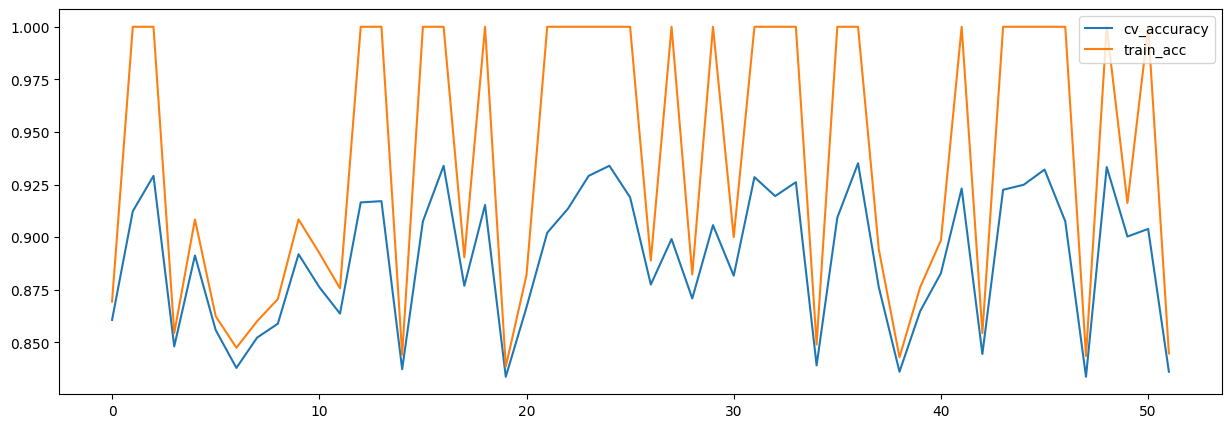

In [84]:
plt.figure(figsize=(15,5))
plt.plot(study.trials_dataframe()["number"],study.trials_dataframe()["value"],label="cv_accuracy")
plt.plot(study.trials_dataframe()["number"],study.trials_dataframe()["user_attrs_train_acc"],label="train_acc")
plt.legend(loc='upper right')
plt.show()

In [85]:
import plotly.express as px
import plotly.graph_objects as go

# Convert Optuna study trials to a DataFrame
trials_df = study.trials_dataframe()

# Create a line plot for CV Accuracy over trials
fig = px.line(
    trials_df,
    x='number',
    y='value',
    title='Study Accuracy over Trials',
    labels={'number': 'Trial Number', 'value': 'CV Accuracy'},
    markers=True,
    width=1500,
    height=500
)

# Customize hover info for CV Accuracy
fig.update_traces(
    hovertemplate='Trial: %{x}<br>Value: %{y}',
    name='CV Accuracy'
)

# Add Train Accuracy trace
fig.add_trace(go.Scatter(
    x=trials_df['number'],
    y=trials_df['user_attrs_train_acc'],
    mode='lines+markers',
    name='Train Accuracy',
    hovertemplate='Trial: %{x}<br>Accuracy: %{y}'
))

# Display the figure
fig.show()


In [86]:
study.best_params #k=20,21,24

{'k': 20, 'w': 'distance', 'a': 'kd_tree'}

Model training

In [87]:
knn=KNeighborsClassifier(n_neighbors=20,weights="distance",algorithm="kd_tree")

In [88]:
model=knn.fit(X_train_scaled,y_train)

## **Genralised Accuracy Score**

In [89]:
accuracy_score(y_test,model.predict(X_test_scaled))

0.9161676646706587

## **Creating Pickle Files for deployment**

In [90]:
import pickle
with open("rs.pkl","wb") as f:
    pickle.dump(rs,f)
with open("oe.pkl","wb") as f:
    pickle.dump(oe,f)
with open("ohe.pkl","wb") as f:
    pickle.dump(ohe,f)
with open("knn.pkl","wb") as f:
    pickle.dump(knn,f)